In [1]:
import scanpy as sc
data_dir = '../../dataset/Human_Great_Apes_filtered.h5ad'
adata = sc.read_h5ad(data_dir)
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 753825891 stored elements and shape (156285, 17413)>
  Coords	Values
  (0, 12862)	0.5665589570999146
  (0, 3064)	0.5665589570999146
  (0, 13278)	3.3999741077423096
  (0, 813)	2.833569049835205
  (0, 13496)	4.101833820343018
  (0, 5722)	2.5798444747924805
  (0, 15309)	7.879579067230225
  (0, 2014)	0.5665589570999146
  (0, 7585)	5.2227888107299805
  (0, 6840)	5.497739791870117
  (0, 12721)	3.967062473297119
  (0, 15364)	1.8461450338363647
  (0, 8240)	1.5708974599838257
  (0, 11878)	2.2390189170837402
  (0, 8802)	5.875441551208496
  (0, 4476)	4.394822597503662
  (0, 10574)	0.5665589570999146
  (0, 16860)	6.168292999267578
  (0, 2182)	5.933631896972656
  (0, 8212)	2.520345449447632
  (0, 7982)	5.331713676452637
  (0, 2798)	5.730631351470947
  (0, 6747)	0.9259976744651794
  (0, 2034)	6.668968677520752
  (0, 9759)	3.3205926418304443
  :	:
  (156284, 2496)	3.841771125793457
  (156284, 12674)	3.841771125793457
  (156284, 3173)	4.524

In [2]:
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder



# 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPAutoEncoder(
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [3]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

18

In [4]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [5]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [6]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

feature
OPN1MW    OPN1MW
KY            KY
COL6A6    COL6A6
EVI2A      EVI2A
UBE2D4    UBE2D4
           ...  
SDF2        SDF2
OSR1        OSR1
SOWAHB    SOWAHB
CHCHD3    CHCHD3
ACTR8      ACTR8
Name: gene_name, Length: 17413, dtype: category
Categories (29813, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYG11AP1', 'ZYG11B', 'ZZEF1', 'ZZZ3']

In [7]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

In [8]:
existing_genes = adata.var['gene_name']
existing_genes

feature
OPN1MW    OPN1MW
KY            KY
COL6A6    COL6A6
EVI2A      EVI2A
UBE2D4    UBE2D4
           ...  
SDF2        SDF2
OSR1        OSR1
SOWAHB    SOWAHB
CHCHD3    CHCHD3
ACTR8      ACTR8
Name: gene_name, Length: 17413, dtype: category
Categories (29813, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYG11AP1', 'ZYG11B', 'ZZEF1', 'ZZZ3']

In [9]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 17413
匹配的基因列表: {'efr3a', 'caly', 'yap1', 'tut4', 'jagn1', 'n4bp2l1', 'or5l2', 'col6a6', 'krtap5-8', 'efcab13', 'kdm8', 'stk31', 'nf1', 'cga', 'znf593', 'efcab11', 'thoc3', 'dnajc11', 'crebrf', 'plcd1', 'ccdc97', 'nt5dc3', 'kcnc2', 'acss2', 'zdhhc11b', 'mthfr', 'rpl37', 'chml', 'bin3', 'olfm4', 'znf701', 'babam2', 'pcdhgb3', 'tmem255a', 'rnf38', 'slc35g2', 'dcaf5', 'ltf', 'igsf9b', 'adamts16', 'rpl22l1', 'ppm1a', 'p3h1', 'rgl3', 'lrpap1', 'znf619', 'art5', 'uprt', 'msn', 'mex3c', 'grb10', 'sp6', 'stat1', 'sfmbt1', 'cpne5', 'artn', 'stxbp5l', 'top2b', 'or6y1', 'n4bp3', 'gcnt4', 'snrpa', 'dgke', 'dtnbp1', 'prtfdc1', 'tirap', 'vps13b', 'znf667', 'zfp30', 'cplx4', 'supt7l', 'faah2', 'ppp2r5c', 'atp5f1a', 'usp17l28', 'lypd8', 'cyp7b1', 'magea10', 'cyb5r2', 'rcc1', 'prss57', 'mrgprx2', 'pgam4', 'znf512b', 'cdh6', 'tjp2', 'mab21l1', 'spanxn2', 'c4orf3', 'brinp3', 'mpc2', 'faf1', 'hdac9', 'lmod2', 'stimate-mustn1', 'nip7', 'ptar1', 'def8', 'copb2', 'ruvbl2', 'atp5mf-ptcd1', 'pp2d1', 'c

set()

In [10]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [11]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 1918
仅在 all_genes 中存在的基因: {'spdye16', 'kel', 'zkscan7', 'cars1', 'cenatac', 'tnk1', 'slc44a4', 'oprl1', 'clic1', 'efcab1', 'prop1', 'tspy4', 'tas2r9', 'capn15', 'gpr22', 'spty2d1os', 'pcdhb12', 'rbfox2', 'nsdhl', 'or10a6', 'ltc4s', 'bfar', 'rinl', 'or11h4', 'fam95c', 'psors1c1', 'actg1', 'slc22a18as', 'abcf1', 'leutx', 'thsd8', 'fam189b', 'ccdc40', 'fam71e2', 'marchf8', 'cep170', 'or5m8', 'armh4', 'fam71c', 'guca1anb', 'eloa3cp', 'ddx39b', 'or10c1', 'mas1l', 'slc39a4', 'ubl7', 'htn1', 'fndc11', 'serf1a', 'ech1', 'or2a14', 'msh5', 'smarcb1', 'csf2ra', 'fam126a', 'vwa7', 'vmac', 'lrrc37a3', 'vasn', 'atf7-npff', 'c1galt1c1', 'arhgap27', 'adcy4', 'fam189a2', 'ddx51', 'ermard', 'pcdha12', 'fam237b', 'mettl9', 'pramef2', 'tex50', 'cbwd6', 'hsfx4', 'asap3', 'znhit3', 'nsmce3', 'poteb3', 'slc39a7', 'bdh1', 'tmem95', 'ppial4f', 'tbcel-tecta', 'slc43a2', 'c16orf91', 'dhrs11', 'ly6g5b', 'fam90a22p', 'ppial4a', 'krtap16-1', 'cfap77', 'krtap9-6', 'ly6g6e', 'c5orf49', 'tcim', 

In [12]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [13]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.20, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [14]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [15]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [16]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.12898028028344655, Validation Loss: 0.017435081899451206
Validation loss improved to 0.017435081899451206, resetting patience.


Epoch 2, Train Loss: 0.020817496737748836, Validation Loss: 0.08236577073403169
No improvement in validation loss. Patience counter: 1/20


Epoch 3, Train Loss: 0.020970718958974933, Validation Loss: 0.09292172713547336
No improvement in validation loss. Patience counter: 2/20


Epoch 4, Train Loss: 0.01062797025959219, Validation Loss: 0.030454239763119922
No improvement in validation loss. Patience counter: 3/20


Epoch 5, Train Loss: 0.004381500612067044, Validation Loss: 0.027646887722340228
No improvement in validation loss. Patience counter: 4/20


Epoch 6, Train Loss: 0.014532492956615678, Validation Loss: 0.02932438920233789
No improvement in validation loss. Patience counter: 5/20


Epoch 7, Train Loss: 0.008037769835064488, Validation Loss: 0.01913535690863478
No improvement in validation loss. Patience counter: 6/20


Epoch 8, Train Loss: 0.006665558213380835, Validation Loss: 0.036540028388587734
No improvement in validation loss. Patience counter: 7/20


Epoch 9, Train Loss: 0.004832347759035705, Validation Loss: 0.025080846085590882
No improvement in validation loss. Patience counter: 8/20


Epoch 10, Train Loss: 0.018410164859735397, Validation Loss: 0.04922336885321588
No improvement in validation loss. Patience counter: 9/20


Epoch 11, Train Loss: 0.009352804816774142, Validation Loss: 0.05077987789352624
No improvement in validation loss. Patience counter: 10/20


Epoch 12, Train Loss: 0.01693675554894272, Validation Loss: 0.03553220641357739
No improvement in validation loss. Patience counter: 11/20


Epoch 13, Train Loss: 0.0015739862269189928, Validation Loss: 0.03711624882783163
No improvement in validation loss. Patience counter: 12/20


Epoch 14, Train Loss: 0.005814756076793782, Validation Loss: 0.033921779762629146
No improvement in validation loss. Patience counter: 13/20


Epoch 15, Train Loss: 0.0018477839326748128, Validation Loss: 0.028240771540879336
No improvement in validation loss. Patience counter: 14/20


Epoch 16, Train Loss: 0.014275222958751412, Validation Loss: 0.026988925482554323
No improvement in validation loss. Patience counter: 15/20


Epoch 17, Train Loss: 0.004429178812157629, Validation Loss: 0.06620445572846119
No improvement in validation loss. Patience counter: 16/20


Epoch 18, Train Loss: 0.0008436195710477749, Validation Loss: 0.043836730463857054
No improvement in validation loss. Patience counter: 17/20


Epoch 19, Train Loss: 0.002312775083820057, Validation Loss: 0.02654795049055507
No improvement in validation loss. Patience counter: 18/20


Epoch 20, Train Loss: 0.01726851689084913, Validation Loss: 0.04194982917610318
No improvement in validation loss. Patience counter: 19/20


Epoch 21, Train Loss: 0.008261033604107775, Validation Loss: 0.03702983116377347
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 21.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


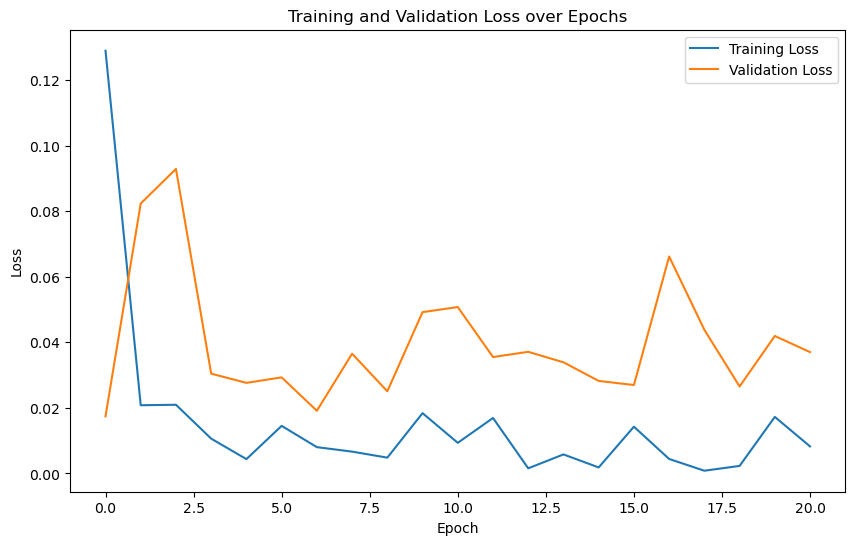

In [17]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_supervised_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_supervised_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [18]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [19]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.9968966951402886
Weighted F1 Score: 0.9968889840139796
Macro F1 Score: 0.9900153510285209
Random Guess Accuracy: 0.32775393340845166
                                                                precision    recall  f1-score   support

     L2/3-6 intratelencephalic projecting glutamatergic neuron       1.00      1.00      1.00     17236
L5 extratelencephalic projecting glutamatergic cortical neuron       1.00      1.00      1.00        87
                             L6b glutamatergic cortical neuron       1.00      1.00      1.00       702
                            VIP GABAergic cortical interneuron       1.00      1.00      1.00      2022
                              astrocyte of the cerebral cortex       1.00      1.00      1.00       639
                caudal ganglionic eminence derived interneuron       0.97      0.91      0.94       162
                              cerebral cortex endothelial cell       0.96      1.00      0.98        27
     

In [20]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Human_Great_Apes_supervised_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['Human_Great_Apes'],
    'method': [re.search(r'Human_Great_Apes_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.129	0.017	1	0.017	0.990	0.997	0.997
